In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'chest-xray-pneumonia:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F17810%2F23812%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240504%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240504T054830Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D796787c078e457a7c1588cebb8d891ae31584c9f41c7e89645a8e830f46f2a99772b90ff25b080ab8da847cf3f40391030b44e5b198859aef797e1fe90a4b9c0271d13e968c5bc26ffa42df5cb8451b845c5c253ba5065ffd0073c58574fe73203b6966fd08ec5d4c13a4b272e72bff430efd7af3cae24b5ec0effe5396d94dc0ca4884211abd0c1ee1004b5764956fa851674db29fee73cc2cfc3158c46c2aabc63fe2dfa29070d40a2f35b7260ed4c86b3a5e870bccfb764bddb283d7f9591b32ecca2530d4abb167654a3b3f35c6c5dd05f23c272348927553abf6fc18ac513e3ec94d31d43f063a1451b30848834a4c2a6c30dcaa91b76e73dd36a22fcef'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

pd.options.display.max_colwidth = 100

import random
import os

from numpy.random import seed
seed(42)

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import glob
import cv2

from tensorflow.random import set_seed
set_seed(42)

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set Matplotlib defaults
sns.set_style('darkgrid')
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

In [ ]:
IMG_SIZE = 224
BATCH = 32
SEED = 42

In [ ]:
print(os.listdir("../input"))

['chest-xray-pneumonia']


In [ ]:
main_path = os.listdir('../input/chest-xray-pneumonia/chest_xray')
print(main_path)

['chest_xray', '__MACOSX', 'val', 'test', 'train']


In [ ]:
train_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/"
val_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/"
test_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/"

In [ ]:
class_names=os.listdir(train_path)
class_names.pop()
print(class_names)

['PNEUMONIA', 'NORMAL']


In [ ]:
train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

val_normal = glob.glob(val_path+"/NORMAL/*.jpeg")
val_pneumonia = glob.glob(val_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

In [ ]:
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

train_df = pd.DataFrame(np.concatenate([["Normal"]*len(train_normal) , ["Pneumomia"]*len(train_pneumonia)]), columns = ['class'])
train_df['image'] = [x for x in train_list]
##########################################################
val_list = [x for x in val_normal]
val_list.extend([x for x in val_pneumonia])

val_df = pd.DataFrame(np.concatenate([["Normal"]*len(val_normal) , ["Pneumomia"]*len(val_pneumonia)]), columns = ['class'])
val_df['image'] = [x for x in val_list]

#########################################################

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

test_df = pd.DataFrame(np.concatenate([["Normal"]*len(test_normal) , ["Pneumomia"]*len(test_pneumonia)]), columns = ['class'])
test_df['image'] = [x for x in test_list]

In [ ]:
train_df

,class,image
0,Normal,/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train//NORMAL/NORMAL2-IM-0771-0001.jpeg
1,Normal,/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train//NORMAL/NORMAL2-IM-1294-0001-0002...
2,Normal,/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train//NORMAL/IM-0675-0001.jpeg
3,Normal,/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train//NORMAL/NORMAL2-IM-1169-0001.jpeg
4,Normal,/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train//NORMAL/IM-0421-0001.jpeg
...,...,...
5211,Pneumomia,/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train//PNEUMONIA/person1541_virus_2681....
5212,Pneumomia,/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train//PNEUMONIA/person799_virus_1431.jpeg
5213,Pneumomia,/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train//PNEUMONIA/person931_virus_1592.jpeg
5214,Pneumomia,/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train//PNEUMONIA/person861_virus_1506.jpeg


In [ ]:
val_df

,class,image
0,Normal,/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val//NORMAL/NORMAL2-IM-1431-0001.jpeg
1,Normal,/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val//NORMAL/NORMAL2-IM-1440-0001.jpeg
2,Normal,/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val//NORMAL/NORMAL2-IM-1442-0001.jpeg
3,Normal,/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val//NORMAL/NORMAL2-IM-1427-0001.jpeg
4,Normal,/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val//NORMAL/NORMAL2-IM-1430-0001.jpeg
5,Normal,/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val//NORMAL/NORMAL2-IM-1436-0001.jpeg
6,Normal,/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val//NORMAL/NORMAL2-IM-1438-0001.jpeg
7,Normal,/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val//NORMAL/NORMAL2-IM-1437-0001.jpeg
8,Pneumomia,/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val//PNEUMONIA/person1947_bacteria_4876...
9,Pneumomia,/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val//PNEUMONIA/person1946_bacteria_4875...


In [ ]:
test_df

,class,image
0,Normal,/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test//NORMAL/NORMAL2-IM-0336-0001.jpeg
1,Normal,/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test//NORMAL/IM-0101-0001.jpeg
2,Normal,/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test//NORMAL/NORMAL2-IM-0337-0001.jpeg
3,Normal,/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test//NORMAL/NORMAL2-IM-0198-0001.jpeg
4,Normal,/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test//NORMAL/IM-0013-0001.jpeg
...,...,...
619,Pneumomia,/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test//PNEUMONIA/person1659_virus_2867.jpeg
620,Pneumomia,/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test//PNEUMONIA/person1615_virus_2801.jpeg
621,Pneumomia,/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test//PNEUMONIA/person1664_virus_2877.jpeg
622,Pneumomia,/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test//PNEUMONIA/person111_bacteria_536....


In [ ]:
# Get the counts for each class
train_cases_count = train_df['class'].value_counts()
print(train_cases_count)


class
Pneumomia    3875
Normal       1341
Name: count, dtype: int64


In [ ]:
val_cases_count = val_df['class'].value_counts()
print(val_cases_count)

class
Normal       8
Pneumomia    8
Name: count, dtype: int64


In [ ]:
test_cases_count = test_df['class'].value_counts()
print(test_cases_count)

class
Pneumomia    390
Normal       234
Name: count, dtype: int64


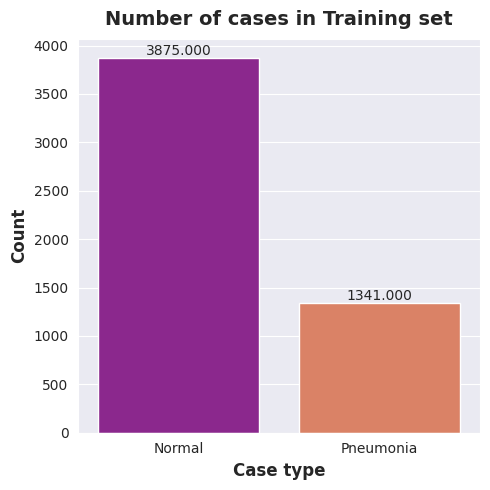

In [ ]:
# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.barplot(x=train_cases_count.index, y= train_cases_count.values, palette = "plasma")
ax.bar_label(ax.containers[0], fmt='%.3f')
plt.title('Number of cases in Training set', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(train_cases_count.index)), ['Normal', 'Pneumonia'])
plt.show()

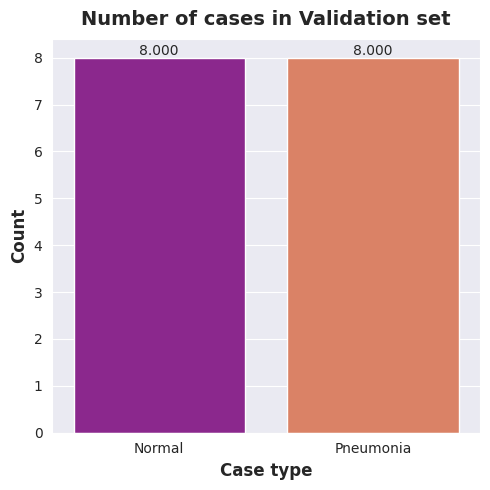

In [ ]:
# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.barplot(x=val_cases_count.index, y= val_cases_count.values, palette = "plasma")
ax.bar_label(ax.containers[0], fmt='%.3f')
plt.title('Number of cases in Validation set', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(val_cases_count.index)), ['Normal', 'Pneumonia'])
plt.show()

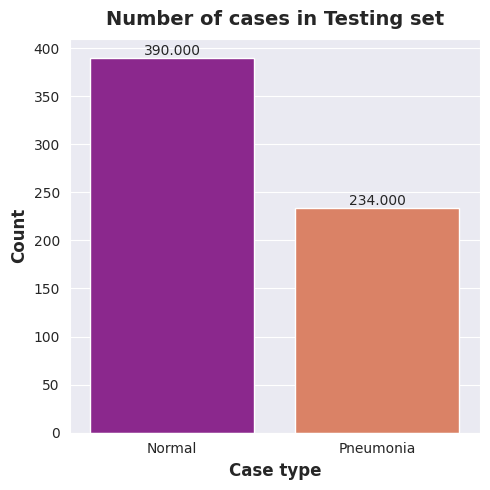

In [ ]:
# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.barplot(x=test_cases_count.index, y= test_cases_count.values, palette = "plasma")
ax.bar_label(ax.containers[0], fmt='%.3f')
plt.title('Number of cases in Testing set', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(test_cases_count.index)), ['Normal', 'Pneumonia'])
plt.show()

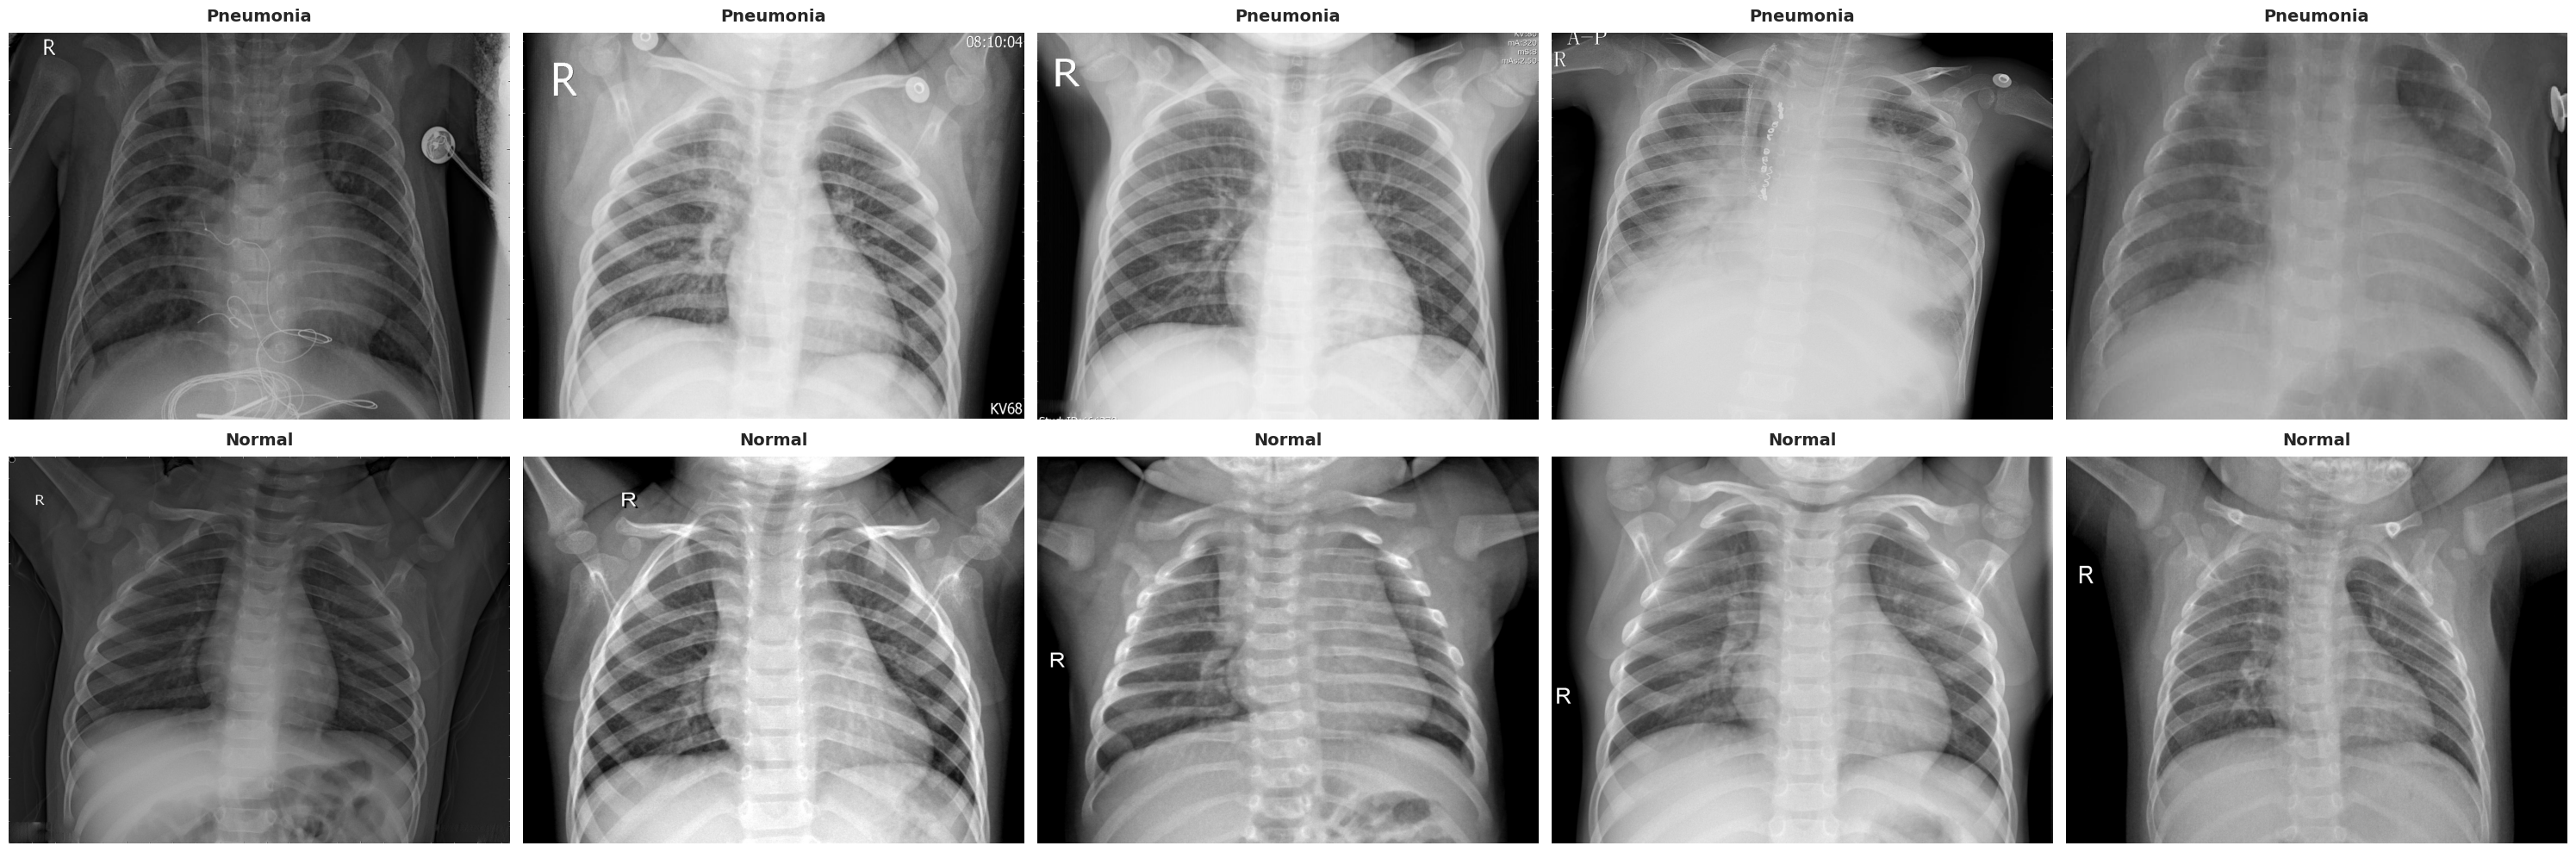

In [ ]:
# Get few samples for both the classes
pneumonia_samples = (train_df[train_df['class']=="Pneumomia"]['image'].iloc[:5]).tolist()
normal_samples = (train_df[train_df['class']=="Normal"]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = cv2.imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

In [ ]:
train_df, val_df = train_test_split(train_df, test_size = 0.20, random_state = SEED, stratify = train_df['class'])

In [ ]:
val_cases_count = val_df['class'].value_counts()
print(val_cases_count)

class
Pneumomia    776
Normal       268
Name: count, dtype: int64


In [ ]:
# https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c

train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  #rotation_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             #directory=train_path, #dataframe contains the full paths
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            #directory=train_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = val_datagen.flow_from_dataframe(test_df,
                                            #directory=test_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

Found 4172 validated image filenames belonging to 2 classes.
Found 1044 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [ ]:
#Setting callbakcs

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,
    patience = 2,
    min_delt = 1e-7,
    cooldown = 0,
    verbose = 1
)

In [ ]:
def get_model():

    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # Block One
    x = layers.Conv2D(filters=16, kernel_size=3, padding='valid')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)

    # Block Two
    x = layers.Conv2D(filters=32, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)

    # Block Three
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.4)(x)

    # Head
    #x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=[inputs], outputs=output)

    return model

In [ ]:
keras.backend.clear_session()

model = get_model()
model.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=3e-5), metrics=['binary_accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 222, 222, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 109, 109, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,560,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,621,089 (10.00 MB)

 Trainable params: 2,620,865 (10.00 MB)

 Non-trainable params: 224 (896.00 B)

In [ ]:
len(ds_train)

131

In [ ]:
history = model.fit(ds_train,
          batch_size = BATCH, epochs = 10,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau])

Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - binary_accuracy: 0.7261 - loss: 0.6380 - val_binary_accuracy: 0.7433 - val_loss: 0.9705 - learning_rate: 3.0000e-05
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - binary_accuracy: 0.8551 - loss: 0.3233 - val_binary_accuracy: 0.7433 - val_loss: 1.7658 - learning_rate: 3.0000e-05
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.8962 - loss: 0.2412
Epoch 3: ReduceLROnPlateau reducing learning rate to 5.9999998484272515e-06.
131/131 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - binary_accuracy: 0.8962 - loss: 0.2412 - val_binary_accuracy: 0.7433 - val_loss: 1.7242 - learning_rate: 3.0000e-05
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - binary_accuracy: 0.9062 - loss: 0.2228 - val_binary_accuracy: 0.7443 - val_loss: 1.0190 - learning_rate: 6.0000e-06
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - binary_accuracy: 0.9124 - loss: 0.2036 - val_binary_accuracy: 0.8669 - val_loss: 0.2631 - learning_rate

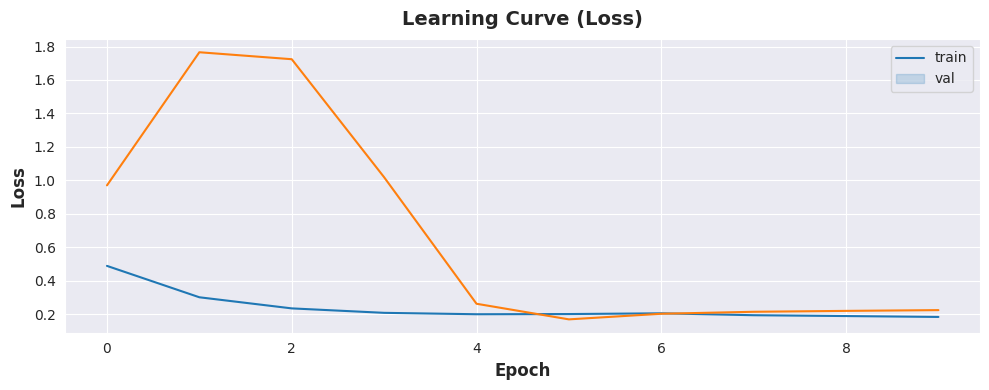

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['train', 'val'])
plt.show()

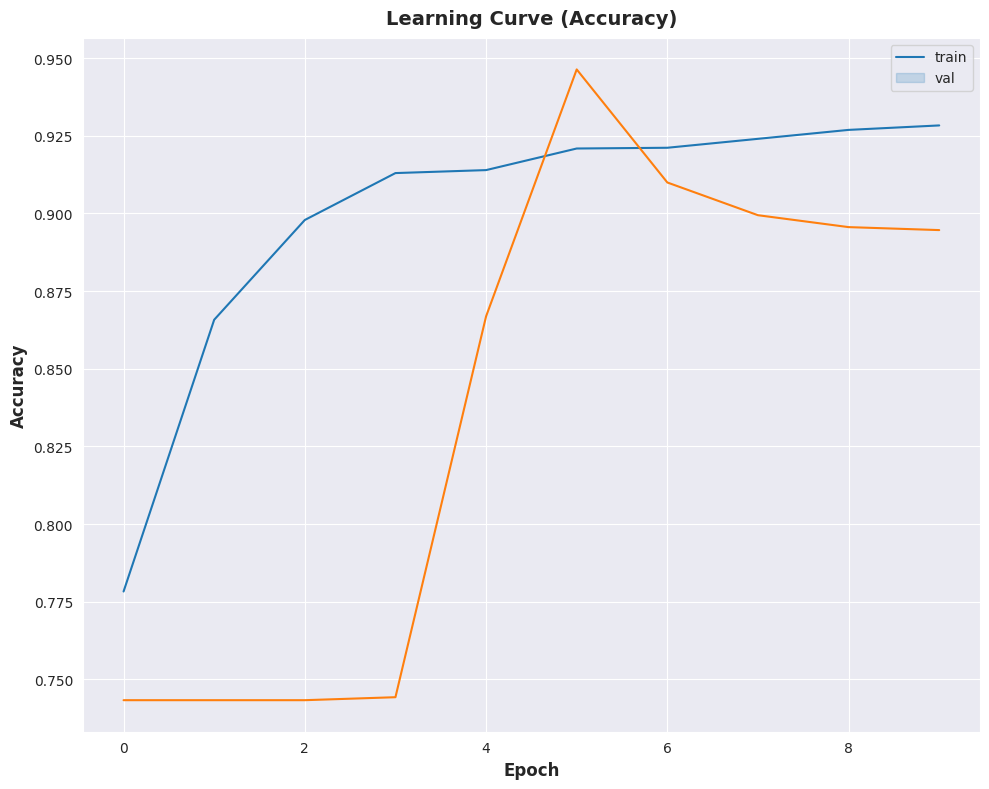

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.legend(['train', 'val'])
plt.show()

In [ ]:
score = model.evaluate(ds_val,  verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.16989274322986603
Val accuracy: 0.946360170841217


In [ ]:
score = model.evaluate(ds_test, verbose = 0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5391446948051453
Test accuracy: 0.8060897588729858
